**Name:** YANG Yongze

**EID:** 58162280

# CS5489 - Tutorial 7
## Image Segmentation using Clustering

In this tutorial you will use clustering algorithms to generate a segmentation of an image.  An image segmentation is a separation of an image into regions belonging to distinct objects.
First we need to initialize Python.  Run the below cell.

In [2]:
%matplotlib inline
import matplotlib_inline   # setup output image format
matplotlib_inline.backend_inline.set_matplotlib_formats('jpg')
# jpg is better for images in this tutorial
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
import glob
import os
import csv
import string
import skimage.io
import skimage.color
import skimage.util
random.seed(100)

##  Loading Data and Pre-processing
Next we need to load the data.  Download `imgdb.zip`, and unzip it in the same directory as this ipynb file.  Then run the following cell to load the image data.

In [3]:
filelist = glob.glob('imgdb/jpg/*.jpg')
gtpath   = 'imgdb/gtruth/'
if len(filelist) == 0:
    warn.error("Could not find imgdb directory!  " + 
               "Make sure you put it here: " + os.getcwd() )
else:
    imgdata = []
    gtdata  = []
    
    # load image data
    for f in filelist:
        # load image - byte [0 to 255]
        img = skimage.io.imread(f)
        
        (fdir1, fname)  = os.path.split(f)        

        # load GT segmentation (non-consecutive integers)
        gname = gtpath + fname[:-4] + "-gt.png"
        gtimg = skimage.io.imread(gname)
        
        # convert to consecutive integers
        cl = unique(gtimg)
        gtimg0 = gtimg.copy().astype(float64)
        for i in range(len(cl)):
            gtimg0[gtimg==cl[i]] = i
        
        imgdata.append(img)
        gtdata.append(gtimg0)
print(len(imgdata))

14


There are 14 images.  Each image also has a ground-truth segmentation that was created by a human annotation.  Here is an example:

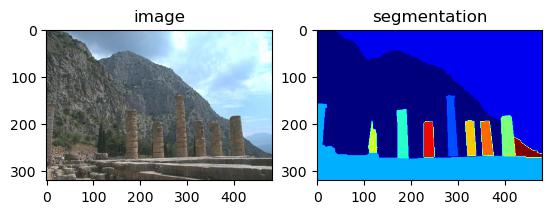

In [4]:
plt.subplot(1,2,1)
plt.imshow(imgdata[6], aspect='equal')
plt.title('image')
plt.subplot(1,2,2)
plt.imshow(gtdata[6], aspect='equal', cmap='jet')
plt.title('segmentation');

##  Clustering with Color Features
To segment an image, we will extract features from each pixel location.  Then, we cluster the extracted features into groups.  Pixel location that are clustered into the same group form a segment.

For the features, we will use the "Lab" colorspace, rather than the RGB colors.  Also, we will ignore the "L" feature, which is brightness, resulting in a 2-dimensional color feature space (a, b). Here are a few helper functions: 1) extract Lab features along a regular grid on the image; 2) convert cluster labels into a segmentation image; 3) color a segmentation image using colors from the original image.

In [5]:
def getfeatures(img, segm=None, stepsize=7, use_loc = False):
    """
    getfeatures - extract features from an image
     [X, Y, L] = getfeatures(img, stepsize)
     INPUT
     img      - the image   [type = np.ndarray or Image]
     segm     - the gt segmentation (optional)
     stepsize - window stepsize
     OUTPUT
      X   - the features: each row is a feature vector  [type = np.ndarray]
      Y   - the GT segment labels for each feature (if segm is provided)
      L   - dictionary containing location information of each feature
    """
    winsize = 7 # ensure it is an odd number
    if stepsize > winsize:
        raise Exception('stepsize larger than window size')
    # convert to LAB
    yimg = skimage.color.rgb2lab(img)

    offset = floor((winsize-1)/2)
    sy,sx, sc = img.shape

    if use_loc:
        Xdim = 4
    else:
        Xdim = 2
    
    # extract window patches with stepsize
    patches = skimage.util.view_as_windows(yimg, (winsize, winsize, 3), step=stepsize)    
    psize = patches.shape
    
    # get coordinates of windows
    rangex = arange(psize[1])*stepsize + offset
    rangey = arange(psize[0])*stepsize + offset

    X = zeros((psize[0] * psize[1], Xdim));
    
    if segm is None:
        Y = None
    else:
        Y = zeros((X.shape[0],))
    
    i = 0
    for x in range(psize[1]):
        for y in range(psize[0]):
            myu = mean(patches[y,x,0,:,:,1].flatten())
            myv = mean(patches[y,x,0,:,:,2].flatten())
            myy = int(rangey[y])
            myx = int(rangex[x])
            
            if use_loc:
                X[i,:] = [myu, myv, myx, myy]
            else:
                X[i,:] = [myu, myv]
                
            if Y is not None:
                Y[i] = segm[myy, myx]
                
            i = i + 1 
    
    L = {'rangex':rangex, 'rangey':rangey, 'offset':offset, 'sx':sx, 'sy':sy, \
         'stepsize':stepsize, 'winsize':winsize}
    return X, Y, L

def labels2seg(Y,L):
    """
    labels2segm - form a segmentation image using cluster labels
    segm = labels2segm(Y, L)
    Y - cluster labels for each location
    L - location dictionary from getfeatures
    segm - output segmentation image
    """
    segm = zeros((L['sy'], L['sx']))
    # <= offset if floor((winsize-1)/2)>= floor(stepsize/2) 
    rstep = int(floor(L['stepsize']/2.0)) 
    stepbox = range(-rstep, L['stepsize'] - rstep)
    rx = asarray(L['rangex'], dtype=int) + int(L['offset'])
    ry = asarray(L['rangey'], dtype=int) + int(L['offset'])
    Y_reshaped = Y.reshape((ry.size, rx.size),order='F')
    for i in stepbox:
        for j in stepbox:
            segm[ix_(ry + j, rx + i)] = Y_reshaped
    ## Now fil in the borders if they are missing
    minx = min(rx) + stepbox[0] - 1
    maxx = max(rx) + stepbox[-1] + 1
    miny = min(ry) + stepbox[0] - 1
    maxy = max(ry) + stepbox[-1] + 1

    if 0 <= minx:
        ## fill in left edge
        segm[:, 0:minx+1] = segm[:,minx+1].reshape((-1,1))
    if maxx < L['sx']:
        ## fill in right edge
        segm[:,maxx:] = segm[:,maxx-1].reshape((-1,1))
    if 0 < miny:
        ## fill in top edge
        segm[0:miny+1,:] = segm[miny+1,:].reshape((1,-1))
    if maxy < L['sy']:
        ## fill in bottom edge
        segm[maxy:,:] = segm[maxy-1,:].reshape((1,-1))
    return segm    

def colorsegms(segm, img):
    """
    colorsegm - color a segmentation based on the image
    csegm = colorsegm(segm, img)
    segm = the segmentation image  [type = np.ndarray]
    img = the original image    [type = np.ndarray (or Image)]
    csegm = the colored segmentation -- each segment is colored based on the 
            average pixel color within the segment.
    """
    img = asarray(img).copy()
    if segm.shape[0:2] != img.shape[0:2]:
        raise Exception('The shape of segmentation and image are not consistent') 
    rimg, gimg, bimg = img[:,:,0], img[:,:,1], img[:,:,2]
    for i in range(0, int(max(segm.flatten())) + 1):
        # assume label starts from 1
        ind = (segm == i)
        rimg[ind] = mean(rimg[ind].flatten())
        gimg[ind] = mean(gimg[ind].flatten())
        bimg[ind] = mean(bimg[ind].flatten())
    # handle outliers from DBSCAN
    ind = (segm == -1)
    rimg[ind] = 0
    gimg[ind] = 0
    bimg[ind] = 0
    return img

Next, we use the `getfeatures` function to extract features from an image.  `X` contains the feature vectors. `L` contains information about where each features was extracted, which is used later generate the segmentation.

(3060, 2)


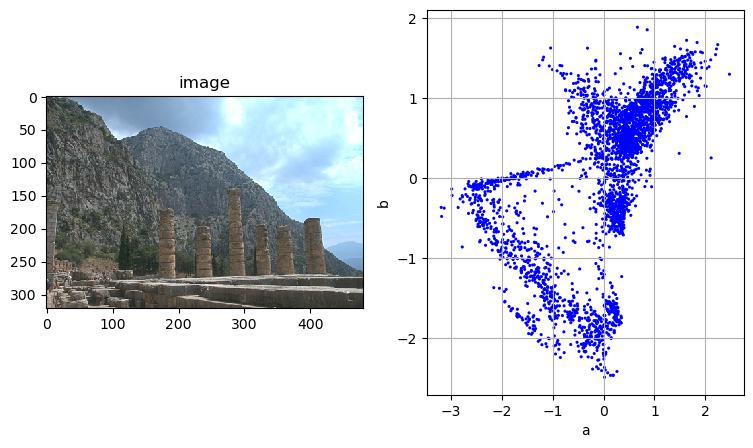

In [50]:
# image to use
img = imgdata[6]
gt  = gtdata[6]

# extract features, each row is a feature vector
Xo,Ytrue, L = getfeatures(img, gt)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# view the image
plt.figure(figsize=(9,5))
plt.subplot(1,2,1)
plt.imshow(img, interpolation='nearest')
plt.title("image")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c='b', s=5, edgecolor='none')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Here is the segmented image, with the segment labels shown as colors.  The goal is to recoever these labels using clustering. 

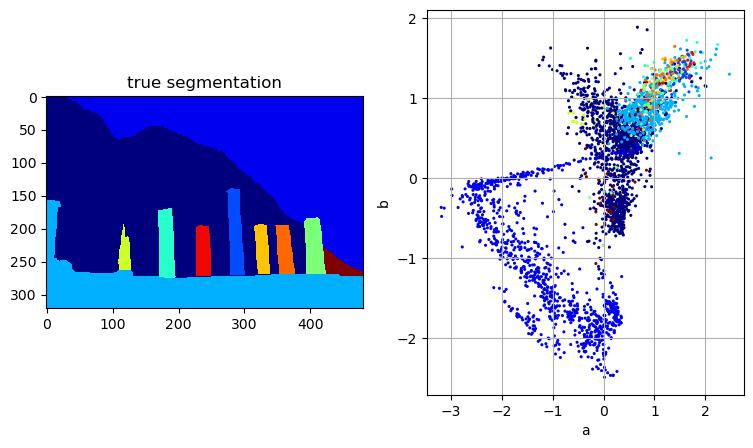

In [7]:
# view the image
plt.figure(figsize=(9,5))

plt.subplot(1,2,1)
plt.imshow(gt, interpolation='nearest', cmap='jet')
plt.title("true segmentation")

# view the features
plt.subplot(1,2,2)
plt.scatter(X[:,0], X[:,1], c=Ytrue, s=5, edgecolor='none', cmap='jet')
plt.ylabel('b'); plt.xlabel('a'); plt.grid(True)

Now use a clustering algorithm to group the data into 5 clusters.

In [ ]:
### INSERT YoUR CODE HERE

In [8]:
kmr = cluster.KMeans(n_clusters=5, random_state=4487, init='random')
Y = kmr.fit_predict(X)

/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Once you have the cluster labels (Y), use the below code to generate the segmentation image and view it.  You can also view the scatter plot with `showscatter`.

In [48]:
def showsegm(segm, img):
    "show a segmentation"
    
    # fill segmentation with colors from the image
    csegm = colorsegms(segm, img)
    
    # view the images, segmentation, and ground-truth
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1)
    plt.imshow(img, interpolation='nearest')
    plt.title('image')
    plt.subplot(1,3,2)
    plt.imshow(segm, interpolation='nearest', cmap='jet')
    plt.title('segmentation')
    plt.subplot(1,3,3)
    plt.imshow(gt, interpolation='nearest', cmap='jet')
    plt.title("ground truth")
    
    return segm

def showscatter(X,Y):
    "show a scatter plot of clusters"
    
    if X.shape[1] == 2:
        plt.figure()
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.grid(True)
        plt.xlabel('a')
        plt.ylabel('b')
    else:
        plt.figure(figsize=(12,3))

        plt.subplot(1,4,1)
        plt.scatter(X[:,0], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('a'); plt.ylabel('b'); plt.grid(True)

        plt.subplot(1,4,2)
        plt.scatter(X[:,2], X[:,3], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('y-pos'); plt.grid(True)

        plt.subplot(1,4,3)
        plt.scatter(X[:,2], X[:,0], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('x-pos'); plt.ylabel('a'); plt.grid(True)

        plt.subplot(1,4,4)
        plt.scatter(X[:,3], X[:,1], c=Y, s=5, edgecolor='none', cmap='jet')
        plt.xlabel('y-pos'); plt.ylabel('b'); plt.grid(True)
        
        plt.tight_layout()

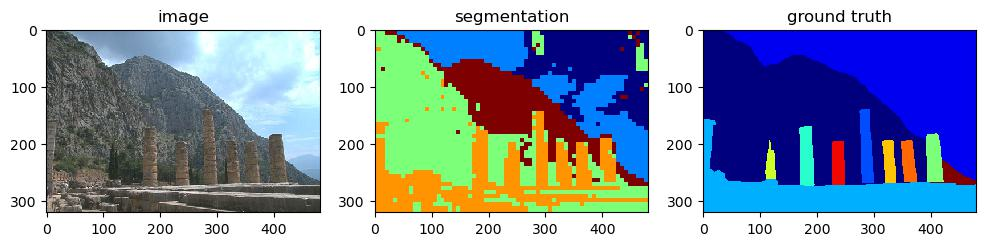

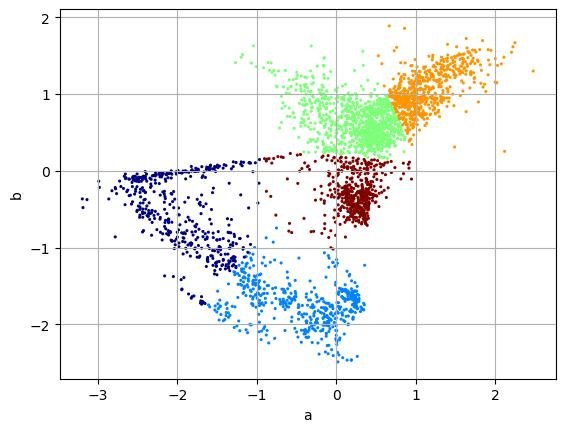

In [10]:
# convert cluster labels to a segmentation image
segm = labels2seg(Y, L)

# show the segmentation
showsegm(segm, img)

# show the scatter plot
showscatter(X,Y)

Next we evaluate the segmentation with the ground-truth provided by a human annotator.  We cannot just check that the cluster assignments for each pixel are the same, since the cluster indices can be permuted.  We will use the _Adjusted Rand Index_, which calculates how often a pair of pixels is assigned correctly to the same cluster or not.  Use the below code to calculate the ARI. Higher values are better, and the maximum value is 1. 

In [11]:
# calculate ARI
#ari = metrics.adjusted_rand_score(gt.flatten(), segm.flatten())
ari = metrics.adjusted_rand_score(Ytrue, Y)
print("ARI =",ari)

ARI = 0.41014157099804266


Try different clustering algorithms and settings (K, bandwidth, etc) to get the best segmentation as measured by ARI. 

First, try **k-means** clustering with different k.

In [14]:
# 1. Try k-means clustering with different k
best_ari = 0
best_k = 0
for k in range(2,10):
    kmr = cluster.KMeans(n_clusters=k, random_state=4487, init='random')
    Y = kmr.fit_predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y)
    print("k={}, ARI: {}".format(k,ari))
    if ari > best_ari:
        best_ari = ari
        best_k = k
print("Best ARI: {}, best K = {}".format(best_ari,best_k))




/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

k=2, ARI: 0.465560581273039
k=3, ARI: 0.3419810063631298
k=4, ARI: 0.5788809624594995
k=5, ARI: 0.41014157099804266
k=6, ARI: 0.3595238078346765
k=7, ARI: 0.2732868752945771
k=8, ARI: 0.3222706284690555
k=9, ARI: 0.2983663371848776
Best ARI: 0.5788809624594995, K = 4


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


We know that when k=4, the ARI reaches the maximum. Now view the segmentation figure and scatter plot.

/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


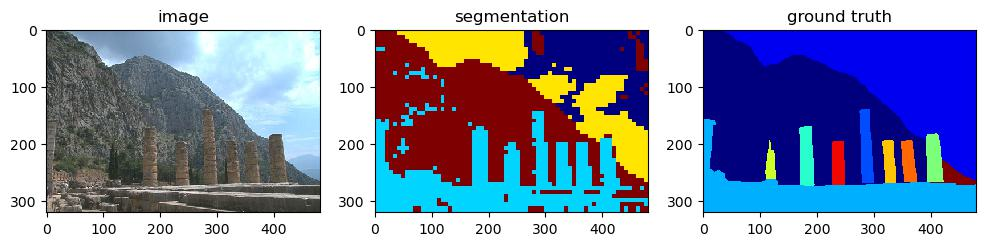

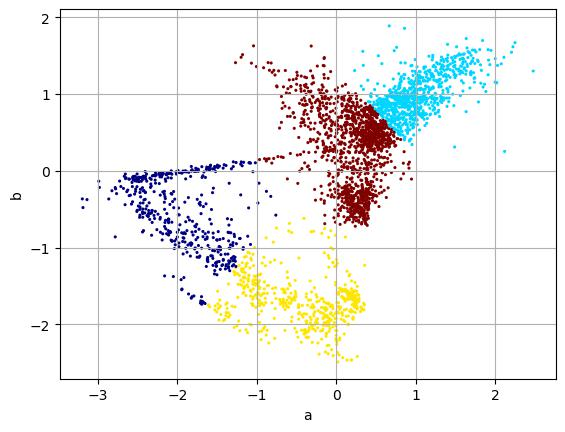

In [15]:
kmr = cluster.KMeans(n_clusters=4, random_state=4487, init='random')
Y = kmr.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

Now try **mini batch k-means** clustering with different k.

In [21]:
# 2.Try Mini Batch k-means clustering with different k
best_ari = 0
best_k = 0
for k in range(2,10):
    kmr = cluster.MiniBatchKMeans(n_clusters=k, random_state=4487, init='random')
    Y = kmr.fit_predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y)
    print("k={}, ARI: {}".format(k,ari))
    if ari > best_ari:
        best_ari = ari
        best_k = k
print("Best ARI: {}, best K = {}".format(best_ari,best_k))

k=2, ARI: 0.4660022412861737
k=3, ARI: 0.4946166376890487
k=4, ARI: 0.5716809192566704
k=5, ARI: 0.4094290610948624
k=6, ARI: 0.34129196887182306
k=7, ARI: 0.34582499731035676
k=8, ARI: 0.2636535733540188
k=9, ARI: 0.25984286907672577
Best ARI: 0.5716809192566704, best K = 4


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will

 Similarly, when k=4, the ARI reaches the maximum. Now view the segmentation figure and scatter plot.

/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


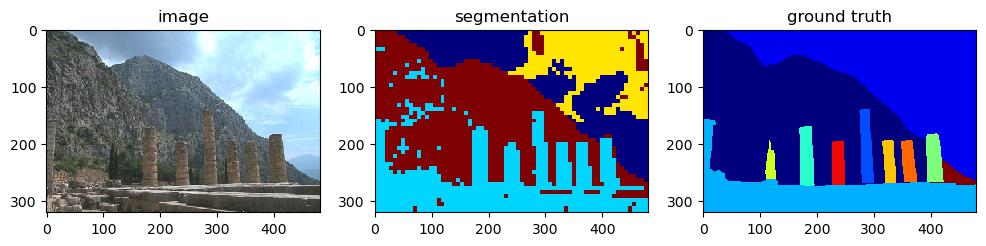

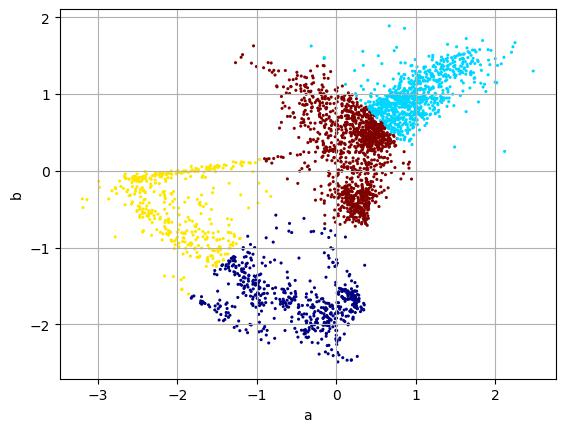

In [22]:
kmr = cluster.MiniBatchKMeans(n_clusters=4, random_state=4487, init='random')
Y = kmr.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

The figures are similar with KMeans. Now use **Gaussian Mixture** with different n_components and different covariance type:

In [32]:
# 3. Try Gaussian Mixture with different n components and covariance type
best_ari = 0
best_n = 0
best_type = ''
for n in range(2,15):
    for type in ['full', 'diag','spherical']:
        gmmf = mixture.GaussianMixture(n_components=n, covariance_type=type,
                                random_state=4487, n_init=10)
        Y = gmmf.fit_predict(X)
        ari = metrics.adjusted_rand_score(Ytrue, Y)
        print("n_components={}, ARI: {}, type: {}".format(n,ari,type))
        if ari > best_ari:
            best_ari = ari
            best_n = n
            best_type = type
print("Best ARI: {}, best n_components: {}, best covariance type: {}".format(best_ari,best_n,best_type))

n_components=2, ARI: 0.4504857648455423, type: full
n_components=2, ARI: 0.3808379117298273, type: diag
n_components=2, ARI: 0.4101173367082469, type: spherical
n_components=3, ARI: 0.518836587227156, type: full
n_components=3, ARI: 0.35086337997190153, type: diag
n_components=3, ARI: 0.3502710363252966, type: spherical
n_components=4, ARI: 0.3805506398562789, type: full
n_components=4, ARI: 0.5846197502901924, type: diag
n_components=4, ARI: 0.5499381981711032, type: spherical
n_components=5, ARI: 0.350152739285423, type: full
n_components=5, ARI: 0.36954503331006977, type: diag
n_components=5, ARI: 0.392633898513814, type: spherical
n_components=6, ARI: 0.22105989524501765, type: full
n_components=6, ARI: 0.316889046056261, type: diag
n_components=6, ARI: 0.3470081942074413, type: spherical
n_components=7, ARI: 0.1722895099201834, type: full
n_components=7, ARI: 0.27575913920490464, type: diag
n_components=7, ARI: 0.2712378294249848, type: spherical
n_components=8, ARI: 0.28960254726

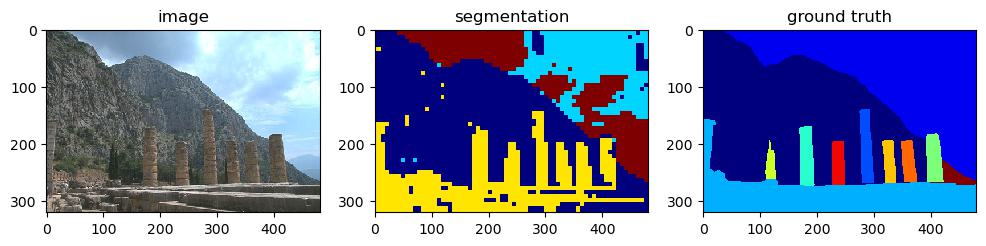

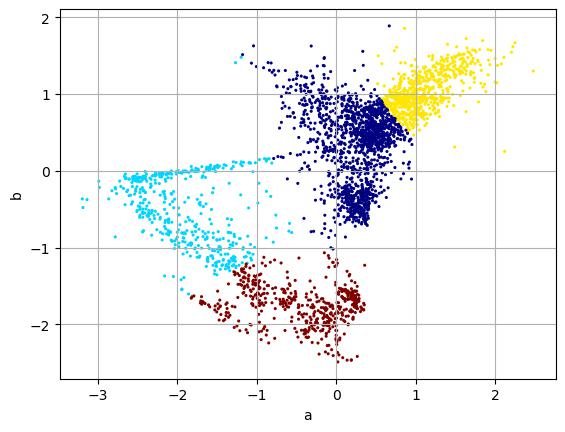

In [33]:
gmmf = mixture.GaussianMixture(n_components=best_n, covariance_type=best_type,
                        random_state=4487, n_init=10)
Y = gmmf.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

Now try **Bayesian Gaussian Mixture** with diferent n_components and different alpha:

In [38]:
# 4. Try Bayesian Gaussian Mixture with different n and alpha
best_ari = 0
best_n = 0
best_alpha = 0
best_type = ''
for n in range(2,15):
    for alpha in logspace(-5,3,5):
        for type in ['full', 'diag','spherical']:
            dpgmm = mixture.BayesianGaussianMixture(n_components=n, weight_concentration_prior=alpha,
                                    covariance_type=type, random_state=4487, n_init=10)
            Y = dpgmm.fit_predict(X)
            ari = metrics.adjusted_rand_score(Ytrue, Y)
            # print("n_components={}, ARI: {}, alpha: {}, type: {}".format(n,ari,alpha,type))
            if ari > best_ari:
                best_ari = ari
                best_n = n
                best_alpha = alpha
                best_type = type
print("Best ARI: {}, best n_components: {}, best alpha: {}, best covariance type: {}".format(best_ari, best_n, best_alpha, best_type))

/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(
/Users/yangy

Best ARI: 0.5739055645232637, best n_components: 4, best alpha: 1e-05, best covariance type: diag


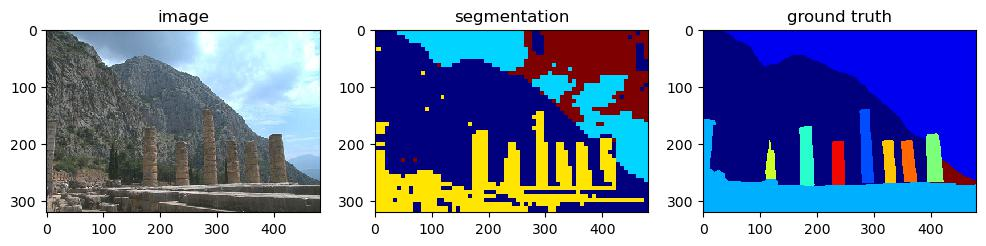

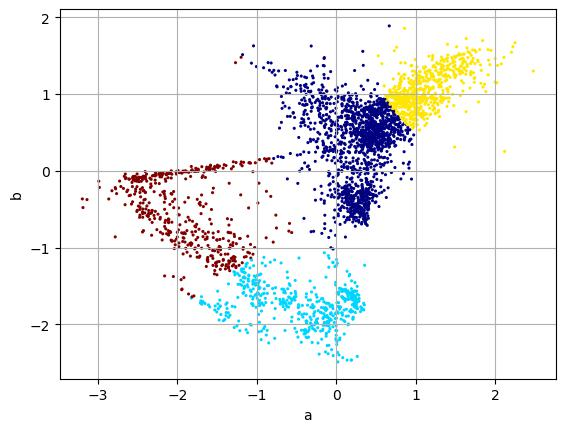

In [39]:
dpgmm = mixture.BayesianGaussianMixture(n_components=best_n, weight_concentration_prior=best_alpha,
                        covariance_type=best_type, random_state=4487, n_init=10)
Y = dpgmm.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

Now try **Mean Shift** with different bandwidth.

In [46]:
# 5. Try Mean Shift clustering with bandwidth
best_ari = 0
best_bandwidth = 0
for bandwidth in arange(0.05,1,0.05):
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=False)
    Y = ms.fit_predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y)
    print("ARI: {}, bandwidth: {}".format(ari,bandwidth))
    if ari > best_ari:
        best_ari = ari
        best_bandwidth = bandwidth
print("Best ARI: {}, best bandwidth: {}".format(best_ari, best_bandwidth))

ARI: 0.0003383508339138721, bandwidth: 0.05
ARI: 0.004230604030780453, bandwidth: 0.1
ARI: 0.014410117819208666, bandwidth: 0.15000000000000002
ARI: 0.03552689070495764, bandwidth: 0.2
ARI: 0.07860523957284866, bandwidth: 0.25
ARI: 0.11577287020236962, bandwidth: 0.30000000000000004
ARI: 0.15348560347051735, bandwidth: 0.35000000000000003
ARI: 0.21008327461636564, bandwidth: 0.4
ARI: 0.2584593532862577, bandwidth: 0.45
ARI: 0.2927018231231433, bandwidth: 0.5
ARI: 0.2440018665506675, bandwidth: 0.55
ARI: 0.31475325106335195, bandwidth: 0.6000000000000001
ARI: 0.35339087600323466, bandwidth: 0.65
ARI: 0.3520948505498633, bandwidth: 0.7000000000000001
ARI: 0.39336531383688167, bandwidth: 0.75
ARI: 0.4067184112944789, bandwidth: 0.8
ARI: 0.3019496547916601, bandwidth: 0.8500000000000001
ARI: 0.31775359794193486, bandwidth: 0.9
ARI: 0.2896301573509743, bandwidth: 0.9500000000000001
Best ARI: 0.4067184112944789, best bandwidth: 0.8


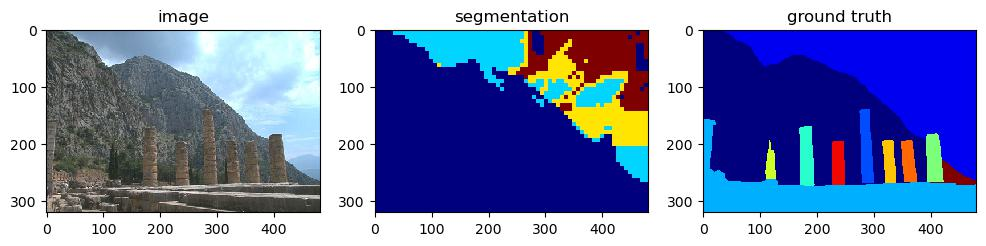

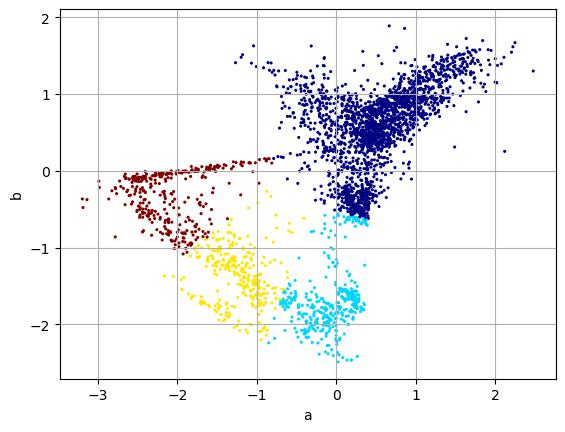

In [51]:
ms = cluster.MeanShift(bandwidth=best_bandwidth, bin_seeding=False)
Y = ms.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

Now use spectral clustering with different gamma and n_clusters.

In [54]:
# 6. Try Spectral clustering with different k
best_ari = 0
best_n = 0
best_gamma = 0
for n in range(2,10):
    for gamma in logspace(-2,1,10):
        sc = cluster.SpectralClustering(n_clusters=n, random_state=4487, gamma=gamma)
        Y = sc.fit_predict(X)
        ari = metrics.adjusted_rand_score(Ytrue, Y)
        # print("n={}, gamma={} ,ARI: {}".format(n,gamma,ari))
        if ari > best_ari:
            best_ari = ari
            best_n = n
            best_gamma = gamma
print("Best ARI: {}, best n = {}, best gamma = ".format(best_ari,best_n,best_gamma))

Best ARI: 0.5831867877459147, best n = 4, best gamma


In [59]:
print(best_gamma)

10.0


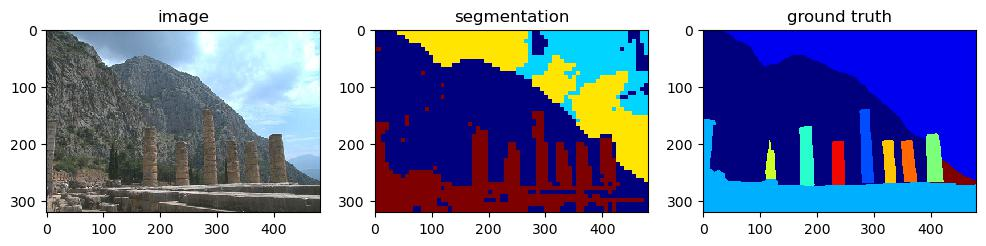

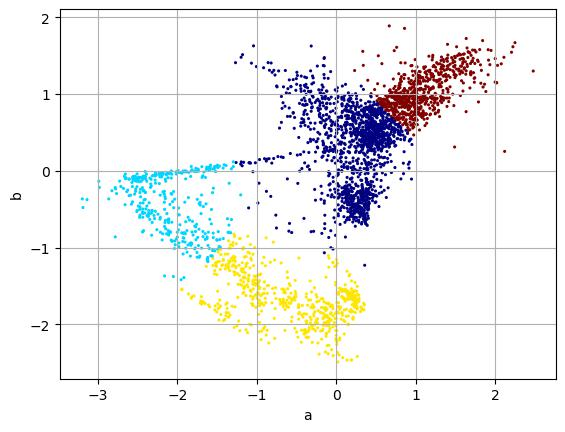

In [55]:

sc = cluster.SpectralClustering(n_clusters=best_n, random_state=4487, gamma=best_gamma)
Y = sc.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

Now use agglomerative clustering.

In [58]:
# 7. Try Agglomerative Clustering with different k
best_ari = 0
best_n = 0

for n in range (2,10):
    ac = cluster.AgglomerativeClustering(n_clusters=n)
    Y = ac.fit_predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y)
    print("n={}, ARI: {}".format(n, ari))
    if ari > best_ari:
        best_ari = ari
        best_n = n
        best_gamma = gamma

print("Best ARI: {}, best n = {}".format(best_ari,best_n))


n=2, ARI: 0.46769705430314873
n=3, ARI: 0.3544099080325621
n=4, ARI: 0.5870720191691665
n=5, ARI: 0.4397291485821988
n=6, ARI: 0.39524403017286563
n=7, ARI: 0.33695882514193826
n=8, ARI: 0.3054966833810184
n=9, ARI: 0.317589807860227
Best ARI: 0.5870720191691665, best n = 4


_Which algorithm performs the best?  Why?_

The ARI of each algorithms are as below:
- 1. k-means: 0.5788809624594995, when K = 4
- 2. Mini Batch k-means: 0.5716809192566704, when K = 4
- 3. Gaussian Mixture: 0.5846197502901924, when n_components= 4 & covariance type = diag
- 4. Bayesian Gaussian Mixture: 0.5739055645232637, when n_components: 4, alpha: 1e-05 & covariance type: diag
- 5. Mean Shift: 0.4067184112944789, when bandwidth = 0.8
- 6. Spectral Clustering: 0.5831867877459147, when n = 4 & best gamma = 10
- 7. Agglomerative Clustering: 0.5870720191691665, when n = 4

We can see that the Agglomerative Clustering has the highest ARI value, and Mean Shift performed the worst.
- The Agglomerative Clustering, Spectral Clustering and the gaussian mixture have an ARI value over 0.58, and the Agglomerative Clustering has the highest ARI value. Agglomerative Clustering is effective to the dataset has a hierarchical structure, while Spectral Clustering is effective to the data has a clear community structure, and the Gaussian Mixture model can measure the uncertainty around the cluster assignments. However, each of the ARI value has only a slightly difference. Therefore, it is difficult to say exactly which of them performs best, as it may be affected by random states and parameters.
- The Mean Shift performed the worst, this may due to that it does not require prior knowledge of the number of clusters.
- Noticed that when cluster numbers is 4 all algorithms reaches the maximum, this could due to the structure of the data.
- For Gaussian Mixture and Bayesian Gaussian Mixture models, the 'diag' covariance type lead to the highest ARI value. This could due to out data that clusters might be uncorrelated.

## Color and Position Features
You may notice that the segmentation is not spatially smooth -- that is, there are some "loner" pixels that are not the same cluster as the surrounding pixels.  This is because we are only clustering color.  One way to fix this is to include the (x,y) coordinate of the pixel as part of the feature vector.  This way, clusters will have pixels that are spatially close together.

The below code extracts a 4-dimensional feature vector, where the first 2 features are the color channels and the last 2 features are the position.

In [61]:
# extract features with location
Xo,Ytrue,L = getfeatures(img, gt, use_loc=True)
print(Xo.shape)

# normalize features
scaler = preprocessing.StandardScaler()  
X = scaler.fit_transform(Xo)

# rescale position features
# larger values emphasize clustering by position more
X[:,2:4] *= 0.5

(3060, 4)


Here are plots of the 4 features.

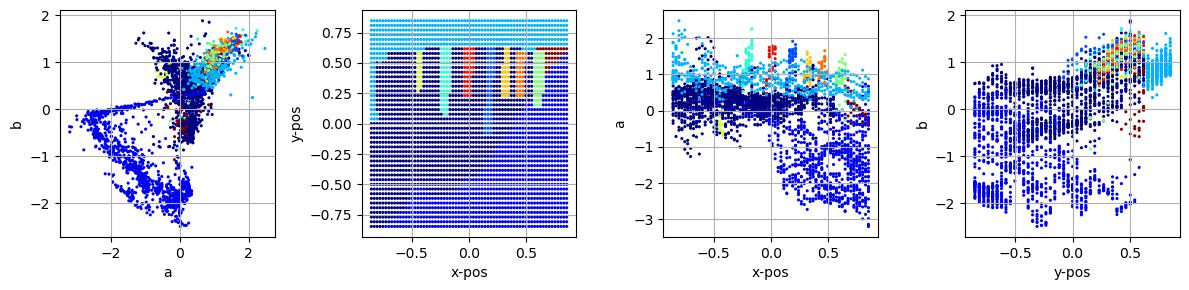

In [62]:
showscatter(X, Ytrue)

Run clustering algorithms on the 4-dimensional data.  Try different algorithms and parameters to get the best ARI.

We can run these seven algorithms again with different parameters.

/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

k=2, ARI: 0.4640151718533962
k=3, ARI: 0.24357239398622899
k=4, ARI: 0.633355010531123
k=5, ARI: 0.45290193467416134
k=6, ARI: 0.40364466941987254


/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init

k=7, ARI: 0.38689828883538435
k=8, ARI: 0.3243413825500212
k=9, ARI: 0.2961370092926161
Best ARI: 0.633355010531123, best K = 4


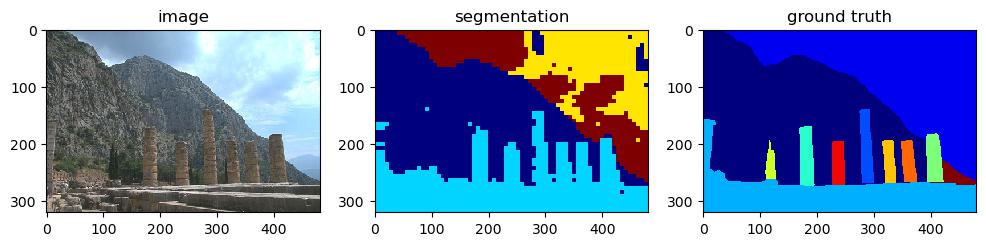

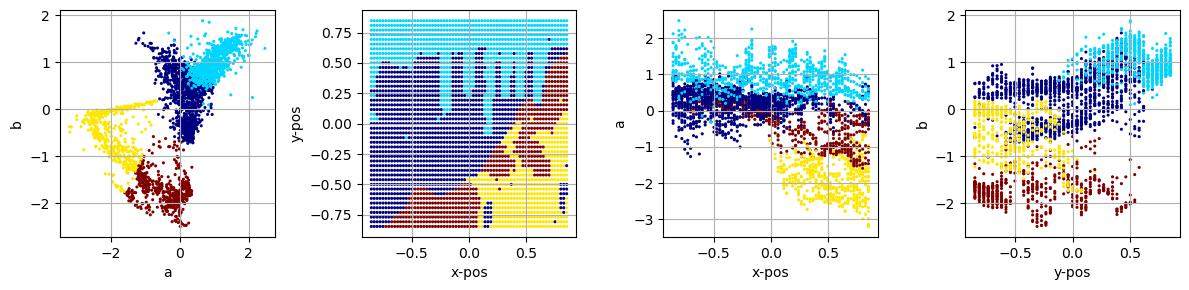

In [64]:
# 1. Try k-means clustering with different k
best_ari = 0
best_k = 0
for k in range(2,10):
    kmr = cluster.KMeans(n_clusters=k, random_state=4487, init='random')
    Y = kmr.fit_predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y)
    print("k={}, ARI: {}".format(k,ari))
    if ari > best_ari:
        best_ari = ari
        best_k = k
print("Best ARI: {}, best K = {}".format(best_ari,best_k))

kmr = cluster.KMeans(n_clusters=best_k, random_state=4487, init='random')
Y = kmr.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/Users/yangyongze/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will

k=2, ARI: 0.4640151718533962
k=3, ARI: 0.6988752450345308
k=4, ARI: 0.5895780453936624
k=5, ARI: 0.5704565411707871
k=6, ARI: 0.3821802520187451
k=7, ARI: 0.315895312519137
k=8, ARI: 0.29970856158502285
k=9, ARI: 0.29201787281631625
Best ARI: 0.6988752450345308, best K = 3


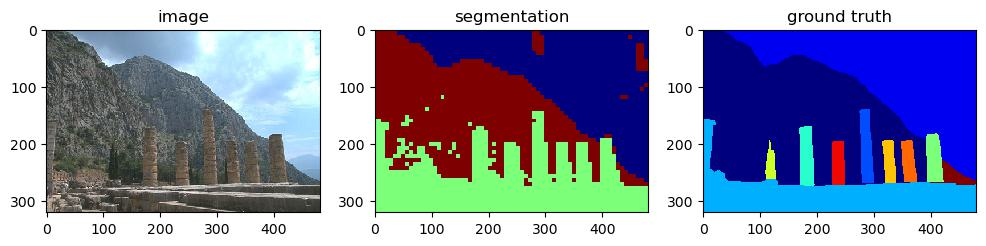

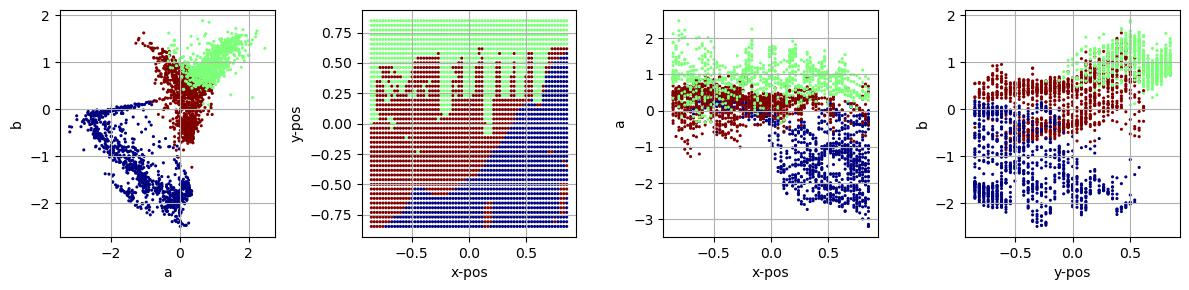

In [65]:
# 2.Try Mini Batch k-means clustering with different k
best_ari = 0
best_k = 0
for k in range(2,10):
    kmr = cluster.MiniBatchKMeans(n_clusters=k, random_state=4487, init='random')
    Y = kmr.fit_predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y)
    print("k={}, ARI: {}".format(k,ari))
    if ari > best_ari:
        best_ari = ari
        best_k = k
print("Best ARI: {}, best K = {}".format(best_ari,best_k))

kmr = cluster.MiniBatchKMeans(n_clusters=best_k, random_state=4487, init='random')
Y = kmr.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

n_components=2, ARI: 0.4555095732170376, type: full
n_components=2, ARI: 0.33731722493899813, type: diag
n_components=2, ARI: 0.45695268161847363, type: spherical
n_components=3, ARI: 0.2520358382834804, type: full
n_components=3, ARI: 0.41247147557820835, type: diag
n_components=3, ARI: 0.3529455985555405, type: spherical
n_components=4, ARI: 0.675361450937292, type: full
n_components=4, ARI: 0.4848225132558542, type: diag
n_components=4, ARI: 0.6387794116969484, type: spherical
n_components=5, ARI: 0.6507466093785076, type: full
n_components=5, ARI: 0.4394949390810123, type: diag
n_components=5, ARI: 0.5936837636941427, type: spherical
n_components=6, ARI: 0.44335424238644655, type: full
n_components=6, ARI: 0.2757406280204754, type: diag
n_components=6, ARI: 0.4140962961977181, type: spherical
n_components=7, ARI: 0.4802622896442017, type: full
n_components=7, ARI: 0.3302774605644275, type: diag
n_components=7, ARI: 0.32309816825310606, type: spherical
n_components=8, ARI: 0.4269560

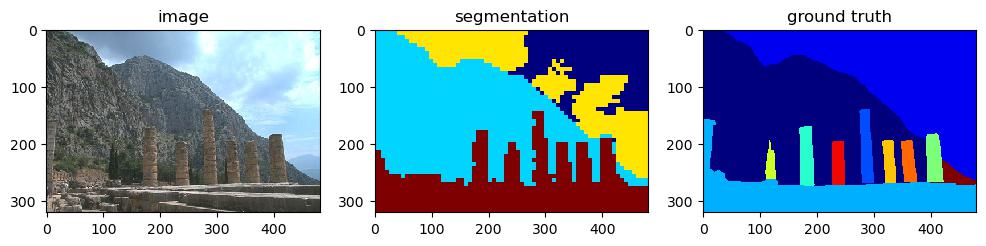

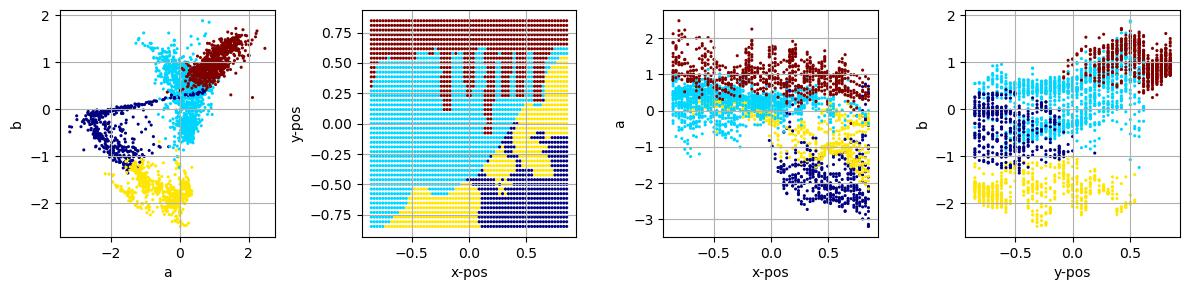

In [66]:
# 3. Try Gaussian Mixture with different n components and covariance type
best_ari = 0
best_n = 0
best_type = ''
for n in range(2,15):
    for type in ['full', 'diag','spherical']:
        gmmf = mixture.GaussianMixture(n_components=n, covariance_type=type,
                                random_state=4487, n_init=10)
        Y = gmmf.fit_predict(X)
        ari = metrics.adjusted_rand_score(Ytrue, Y)
        print("n_components={}, ARI: {}, type: {}".format(n,ari,type))
        if ari > best_ari:
            best_ari = ari
            best_n = n
            best_type = type
print("Best ARI: {}, best n_components: {}, best covariance type: {}".format(best_ari,best_n,best_type))

gmmf = mixture.GaussianMixture(n_components=best_n, covariance_type=best_type,
                        random_state=4487, n_init=10)
Y = gmmf.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

Best ARI: 0.7209850800591139, best n_components: 4, best alpha: 1e-05, best covariance type: full


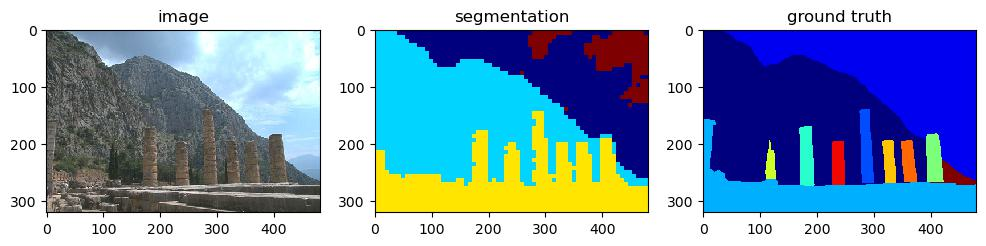

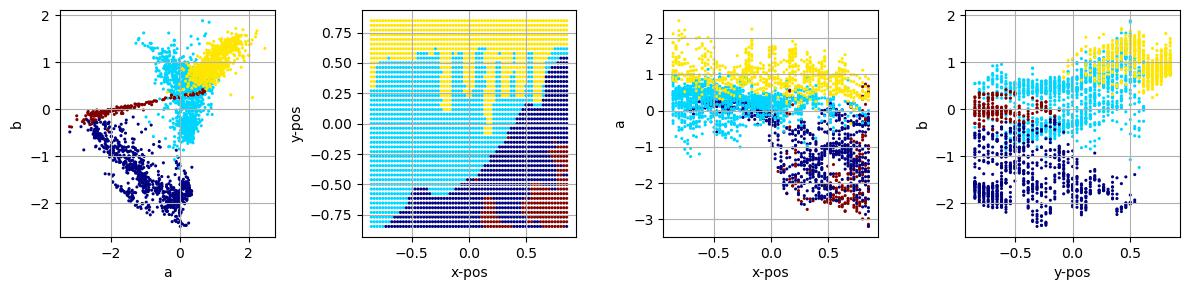

In [67]:
# 4. Try Bayesian Gaussian Mixture with different n and alpha
best_ari = 0
best_n = 0
best_alpha = 0
best_type = ''
for n in range(2,15):
    for alpha in logspace(-5,3,5):
        for type in ['full', 'diag','spherical']:
            dpgmm = mixture.BayesianGaussianMixture(n_components=n, weight_concentration_prior=alpha,
                                    covariance_type=type, random_state=4487, n_init=10)
            Y = dpgmm.fit_predict(X)
            ari = metrics.adjusted_rand_score(Ytrue, Y)
            # print("n_components={}, ARI: {}, alpha: {}, type: {}".format(n,ari,alpha,type))
            if ari > best_ari:
                best_ari = ari
                best_n = n
                best_alpha = alpha
                best_type = type
print("Best ARI: {}, best n_components: {}, best alpha: {}, best covariance type: {}".format(best_ari, best_n, best_alpha, best_type))


dpgmm = mixture.BayesianGaussianMixture(n_components=best_n, weight_concentration_prior=best_alpha,
                        covariance_type=best_type, random_state=4487, n_init=10)
Y = dpgmm.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)


ARI: 0.0003383508339138721, bandwidth: 0.05
ARI: 0.004230604030780453, bandwidth: 0.1
ARI: 0.014410117819208666, bandwidth: 0.15000000000000002
ARI: 0.03552689070495764, bandwidth: 0.2
ARI: 0.07860523957284866, bandwidth: 0.25
ARI: 0.11577287020236962, bandwidth: 0.30000000000000004
ARI: 0.15348560347051735, bandwidth: 0.35000000000000003
ARI: 0.21008327461636564, bandwidth: 0.4
ARI: 0.2584593532862577, bandwidth: 0.45
ARI: 0.2927018231231433, bandwidth: 0.5
ARI: 0.2440018665506675, bandwidth: 0.55
ARI: 0.31475325106335195, bandwidth: 0.6000000000000001
ARI: 0.35339087600323466, bandwidth: 0.65
ARI: 0.3520948505498633, bandwidth: 0.7000000000000001
ARI: 0.39336531383688167, bandwidth: 0.75
ARI: 0.4067184112944789, bandwidth: 0.8
ARI: 0.3019496547916601, bandwidth: 0.8500000000000001
ARI: 0.31775359794193486, bandwidth: 0.9
ARI: 0.2896301573509743, bandwidth: 0.9500000000000001
Best ARI: 0.4067184112944789, best bandwidth: 0.8


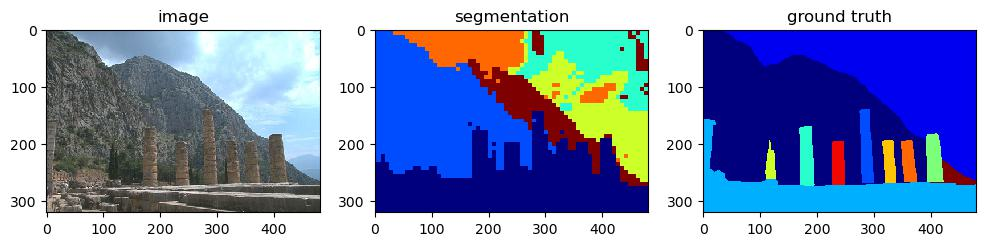

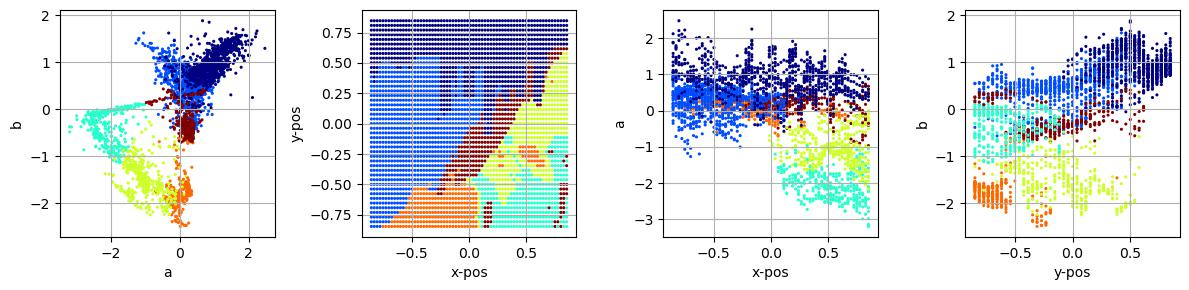

In [68]:
# 5. Try Mean Shift clustering with bandwidth
best_ari = 0
best_bandwidth = 0
for bandwidth in arange(0.05,1,0.05):
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=False)
    Y = ms.fit_predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y)
    print("ARI: {}, bandwidth: {}".format(ari,bandwidth))
    if ari > best_ari:
        best_ari = ari
        best_bandwidth = bandwidth
print("Best ARI: {}, best bandwidth: {}".format(best_ari, best_bandwidth))

ms = cluster.MeanShift(bandwidth=best_bandwidth, bin_seeding=False)
Y = ms.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

Best ARI: 0.6995176855121427, best n = 4, best gamma = 10.0


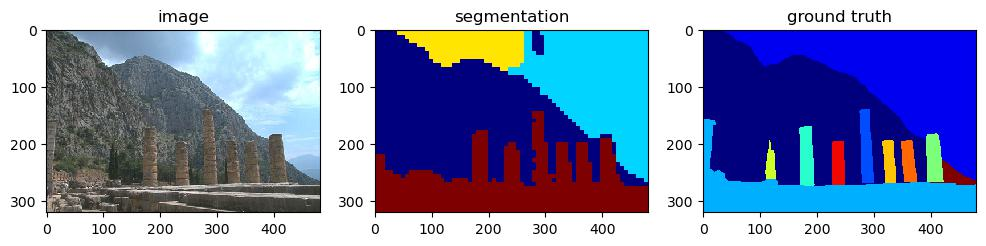

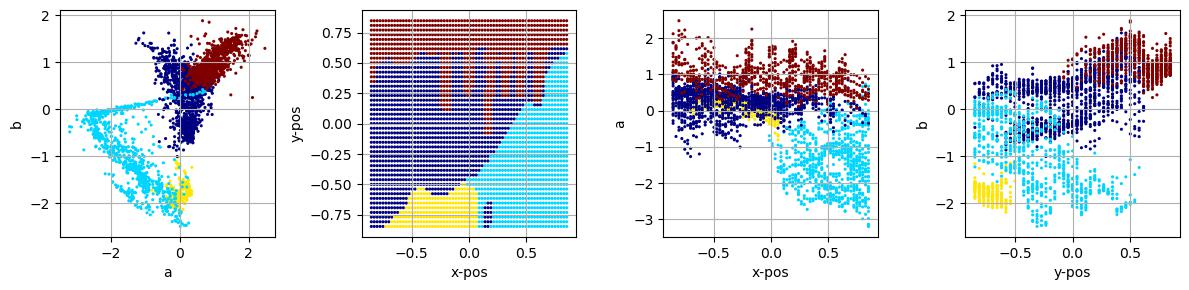

In [69]:
# 6. Try Spectral clustering with different k
best_ari = 0
best_n = 0
best_gamma = 0
for n in range(2,10):
    for gamma in logspace(-2,1,10):
        sc = cluster.SpectralClustering(n_clusters=n, random_state=4487, gamma=gamma)
        Y = sc.fit_predict(X)
        ari = metrics.adjusted_rand_score(Ytrue, Y)
        # print("n={}, gamma={} ,ARI: {}".format(n,gamma,ari))
        if ari > best_ari:
            best_ari = ari
            best_n = n
            best_gamma = gamma
print("Best ARI: {}, best n = {}, best gamma = {}".format(best_ari,best_n,best_gamma))


sc = cluster.SpectralClustering(n_clusters=best_n, random_state=4487, gamma=best_gamma)
Y = sc.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

n=2, ARI: 0.47561479887550634
n=3, ARI: 0.3690868515792056
n=4, ARI: 0.6550073152184945
n=5, ARI: 0.47133143888774787
n=6, ARI: 0.41356704628788116
n=7, ARI: 0.3329787185203933
n=8, ARI: 0.3370641806323106
n=9, ARI: 0.31015181261808533
Best ARI: 0.6550073152184945, best n = 4


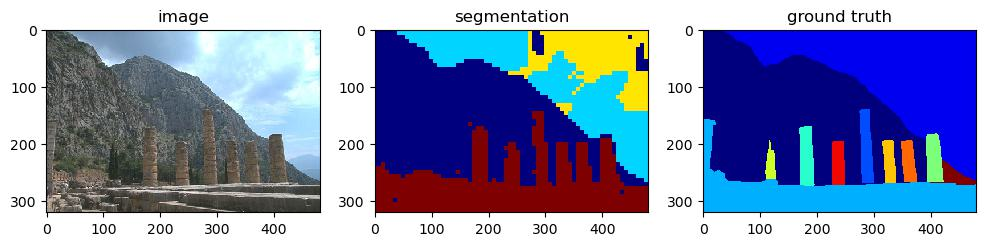

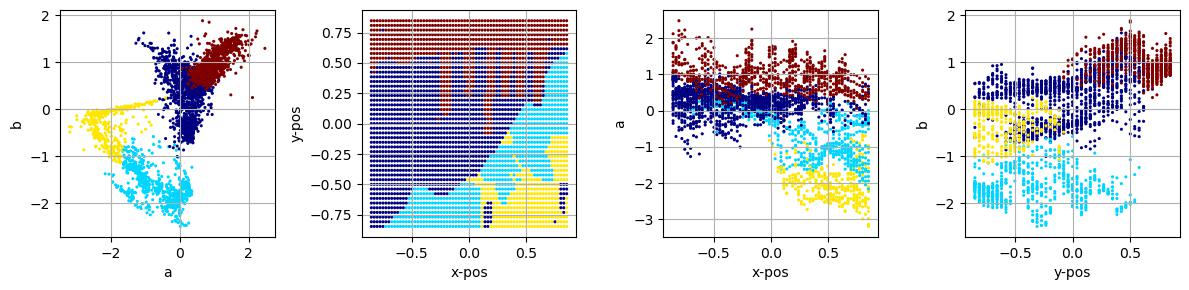

In [70]:
# 7. Try Agglomerative Clustering with different k
best_ari = 0
best_n = 0

for n in range (2,10):
    ac = cluster.AgglomerativeClustering(n_clusters=n)
    Y = ac.fit_predict(X)
    ari = metrics.adjusted_rand_score(Ytrue, Y)
    print("n={}, ARI: {}".format(n, ari))
    if ari > best_ari:
        best_ari = ari
        best_n = n
        best_gamma = gamma

print("Best ARI: {}, best n = {}".format(best_ari,best_n))



sc = cluster.AgglomerativeClustering(n_clusters=best_n)
Y = sc.fit_predict(X)

segm = labels2seg(Y, L)
showsegm(segm, img)
showscatter(X,Y)

_Which method performs the best?  Why?_

The ARI of each algorithms are as below:
- 1. k-means: 0.633355010531123, when K = 4
- 2. Mini Batch k-means: 0.6988752450345308, when K = 3
- 3. Gaussian Mixture: 0.675361450937292, when n_components= 4 & covariance type = full
- 4. Bayesian Gaussian Mixture: 0.7209850800591139, when n_components: 4, alpha: 1e-05 & covariance type: full
- 5. Mean Shift: 0.4067184112944789, when bandwidth = 0.8
- 6. Spectral Clustering: 0.6995176855121427, when n = 4 & best gamma = 10
- 7. Agglomerative Clustering: 0.6550073152184945, when n = 4

We can see that the Bayesian Gaussian Mixture algorithm has the highest ARI value and performs the best. 
- The Bayesian Gaussian Mixture Algorithms assume that each cluster follows a Gaussian distribution and maximiaze the likelihood of gata given these distributions. 
- When the spatial position features are added, there will be more dimensions follows the distribution, which will help the Bayesian Gaussian Mixture Algorithm to better estimate the parameters, therefore the performance is improved.
- Also, the Bayesian approach can compute the probability of a point belonging to each cluster instead of making hard assignments of points to clusters, which may lead to a more robust performance.

_Does including the position features improve the segmentation results?_

- Yes, the inclusion of the position features significantly improves the segmentation results.
- In the previous part, the clusters are grouped based on their color similarity. When two pixel have similar colors but have different positions, due to the fact that the picture have only color features, the algorithms may be not able to distinguish them and more likely to regard them as the same.
- When the position features are added, more context about the pixel are given, and the spatial proximity are considered. Therefore, the pixels not only have similar colors but also close in spatial position are more likely to belong to the same cluster.